## Use the xG predictions to score the model in terms of money gained or lost
Components needed:
1. Model xG predictions aggregated to the team/game level
2. ML odds of each particular team/game
3. Score/result of each game

Steps to accomplish this:
1. Assign each row in the teams xG df the correct game ID located in the season scores df
2. Group the teams xG df by the game ID and calculate the probability of winning (using poisson function)
3. Join the probabilities to the odds data frame
4. Get the EV of each bet using the odds and the probability of each team winning
5. Join which bets won using scores of each game

--

6. Decide which wagers to place using the various combinations of bet restrictions. For each combination... 
7. Create column containing the gain/loss in terms of units of each bet. If we did not place a bet, the value is 0
8. Sum the profit column to determine the total gain/loss over the betting period

--

9. Choose the best set of restrictions that maximizes profit, etc.
10. Redo computations using best restriction set
11. Visualize various aspects of the results


In [1]:
# Libraries
import pandas as pd
from scipy.stats import poisson
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
# Poisson win rate function
def get_poisson_win_rate(df_group):
    # Gather the expected goals for each team in the group
    xg = df_group['xG'].tolist()
    xgA = xg[0]
    xgB = xg[1]

    # Assume that  NHL teams score between 0 and 25 goals per game
    num_goals = [n for n in range(25)]

    # Get probabilities of scoring 0-20 from poisson distribution with mean xGoals
    pois_probsA = poisson.pmf(k = num_goals, mu = xgA)
    pois_probsB = poisson.pmf(k = num_goals, mu = xgB)

    # Set up df to store probabilities
    poisA = pd.DataFrame(zip(num_goals, pois_probsA), columns = ['goalsA', 'probA'])
    poisA['temp_key'] = 1

    poisB = pd.DataFrame(zip(num_goals, pois_probsB), columns = ['goalsB', 'probB'])
    poisB['temp_key'] = 1

    # Join on temporary key to get cross join
    all_outcomes = pd.merge(poisA, poisB, how = 'inner', on = 'temp_key').drop(columns = 'temp_key')

    # Calculate probability of each possible outcome
    all_outcomes['outcome_prob'] = all_outcomes['probA'] * all_outcomes['probB']

    # Get probability that team A wins. Pr(A win) = SUM(A > B) + 0.5 * SUM(A = B)
    prob_A_win = all_outcomes.loc[all_outcomes['goalsA'] > all_outcomes['goalsB'], 'outcome_prob'].sum() + 0.5 * all_outcomes.loc[all_outcomes['goalsA'] == all_outcomes['goalsB'], 'outcome_prob'].sum()

    # Get probability that team B wins
    prob_B_win = 1-prob_A_win

    # Assign these probabilities to a new column in the data frame
    df_group['win_prob'] = [prob_A_win, prob_B_win]
 
    # Return the result for each group
    return df_group

In [3]:
# EV functions
# Function to convert odds (ex: -125, +200) to a profit in units assuming it wins
def odds_to_profit(odds):
    odds = int(odds)
    if odds > 0:
        payout = (odds / 100) # + 1 if you want odds to payout
    else:
        payout = (100 / abs(odds)) # + 1
    return payout

# Function to get the expected value of each bet
def get_bet_EV(odds, prob):
    profit = odds_to_profit(odds)
    return (prob) * (profit) - (1 - prob)

In [4]:
# Determines profit of a bet depending on whether we placed the bet and whether it was a winner
def determine_bet_profit(odds, place_bet_flag, win_flag):
    if place_bet_flag == 0:
        return 0
    elif win_flag == 0:
        return -1
    else:
        return odds_to_profit(odds)

In [5]:
# 3 data files we need
team_xG = pd.read_csv('../data/evaluation_predictions/rf_test_021323.csv')
scores_2023 = pd.read_csv('../data/season_scores/scores_2023')
odds = pd.read_csv('../data/odds/ml_odds.csv').drop(columns='game_id') # Need to remove this column if the join works correctly

### Step 1-3: Assign win game id's and calculate win rates

In [6]:
# Assign game IDs to each row
team_xG = pd.merge(team_xG, scores_2023, how = 'left', on = ['date', 'team'])[['date', 'team', 'game_id', 'xG']]

In [7]:
# Calculate poisson win rate for each team within each game
team_win_rates = team_xG.groupby('game_id').apply(get_poisson_win_rate).reset_index(drop=True)
team_win_rates.head()

,date,team,game_id,xG,win_prob
0,2023-02-13,BUF,23847,3.102259,0.449803
1,2023-02-13,LAK,23847,3.431125,0.550197
2,2023-02-13,FLA,23848,3.778146,0.582580
3,2023-02-13,MIN,23848,3.216799,0.417420
4,2023-02-13,ARI,23849,2.695284,0.485718


In [8]:
# Join the win probabilities to the odds data
odds_and_win_rate = pd.merge(odds, team_win_rates, how = 'left', left_on = ['date_game', 'team'], right_on = ['date', 'team'])[['game_id', 'date_game', 'team', 'ml_odds', 'win_prob']]
odds_and_win_rate.head()

,game_id,date_game,team,ml_odds,win_prob
0,23850,2023-02-13,CGY,-165,0.488800
1,23850,2023-02-13,OTT,140,0.511200
2,23849,2023-02-13,ARI,200,0.485718
3,23849,2023-02-13,NSH,-240,0.514282
4,23848,2023-02-13,FLA,-110,0.582580


In [9]:
odds_and_win_rate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 932 entries, 0 to 931
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   game_id    932 non-null    int64  
 1   date_game  932 non-null    object 
 2   team       932 non-null    object 
 3   ml_odds    932 non-null    int64  
 4   win_prob   932 non-null    float64
dtypes: float64(1), int64(2), object(2)
memory usage: 36.5+ KB


### Step 4-5: Get EV of each bet. Join which bets won using scores of each game

In [10]:
# Assign EV to each bet
bet_analysis = odds_and_win_rate.copy()
bet_analysis['EV'] = odds_and_win_rate.apply(lambda row: get_bet_EV(row['ml_odds'], row['win_prob']), axis = 1)

# Append column containing the outcome of each bet
bet_analysis = pd.merge(bet_analysis, scores_2023, how = 'left', on = ['game_id', 'team'])[['game_id', 'date_game', 'team', 'ml_odds', 'win_prob', 'EV', 'win_flag']]

### Steps 6-8: 
Create function to try various bet restrictions

In [11]:
def evaluate_wagers(df_bets, EV_lower = 0.30, odds_lower = -200, odds_upper = 250):
    # Copy of original df
    df_bets_copy = df_bets.copy()

    # Decide which wagers to place
    df_bets_copy['place_bet_flag'] = 0
    df_bets_copy.loc[(df_bets_copy['EV'] >= EV_lower) & (df_bets_copy['ml_odds'] >= odds_lower) & (df_bets_copy['ml_odds'] <= odds_upper), 'place_bet_flag'] = 1

    # Create profit column
    df_bets_copy['profit'] = df_bets_copy.apply(lambda row: determine_bet_profit(row['ml_odds'], row['place_bet_flag'], row['win_flag']), axis = 1)

    # Save the toal profit
    profit = df_bets_copy['profit'].sum()

    # Df of only bets placed
    df_bets_placed = df_bets_copy[df_bets_copy['place_bet_flag'] == 1]

    # Total number of bets
    n_bets_placed = len(df_bets_placed)

    # Average gain/loss per bet
    avg_profit = df_bets_copy['profit'].sum() / n_bets_placed

    return profit, n_bets_placed, avg_profit

### Apply function on a variety of different combinations of restrictions

In [12]:
# Set up data frame to log results of bet choices
restriction_list = pd.DataFrame({
    'EV_lower':np.repeat([0.10, 0.20, 0.30, 0.40], 4),
    'odds_lower':-200,
    'odds_upper':(4 * [125, 150, 200, 250]),
    'profit':np.nan,
    'n_bets_placed':np.nan,
    'avg_profit':np.nan
})

In [13]:
# Run function on the list of different restrictions
restriction_list[['profit', 'n_bets_placed', 'avg_profit']] = restriction_list.apply(lambda row: pd.Series(evaluate_wagers(bet_analysis, row['EV_lower'], row['odds_lower'], row['odds_upper'])), axis = 1)

/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_17944/1442551287.py:22: RuntimeWarning: invalid value encountered in scalar divide
  avg_profit = df_bets_copy['profit'].sum() / n_bets_placed
/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_17944/1442551287.py:22: RuntimeWarning: invalid value encountered in scalar divide
  avg_profit = df_bets_copy['profit'].sum() / n_bets_placed


In [14]:
# View which restrictions gave the most profit
restriction_list.sort_values('profit', ascending=False)

,EV_lower,odds_lower,odds_upper,profit,n_bets_placed,avg_profit
1,0.1,-200,150,11.409091,91.0,0.125375
5,0.2,-200,150,11.250000,36.0,0.312500
9,0.3,-200,150,3.050000,4.0,0.762500
10,0.3,-200,200,2.050000,33.0,0.062121
7,0.2,-200,250,1.900000,135.0,0.014074
8,0.3,-200,125,1.250000,1.0,1.250000
12,0.4,-200,125,0.000000,0.0,NaN
13,0.4,-200,150,0.000000,0.0,NaN
4,0.2,-200,125,-0.300000,9.0,-0.033333
6,0.2,-200,200,-0.350000,89.0,-0.003933


### Step 9: Choose the best restrictions under the following conditions
* The total profit must be within 10% of the best profit in terms of units (10% is subjective)
* There must be at least ~ 2 bets placed per week
* Choose the set with the highest average profit

In [15]:
# Find the best set of restrictions
# Total profit condition
profit_threshold = restriction_list['profit'].max() - 0.10 * restriction_list['profit'].max()

# Bet frequency condition (using 0.25 bets per day)
min_date = bet_analysis['date_game'].min()
max_date = bet_analysis['date_game'].max()

min_date = datetime.strptime(min_date, '%Y-%m-%d')
max_date = datetime.strptime(max_date, '%Y-%m-%d')
dayspan = (max_date - min_date).days
n_bets_threshold = 0.25 * dayspan

# Filter for the eligible restrictions
eligible_restrictions = restriction_list[(restriction_list['profit'] >= profit_threshold) & (restriction_list['n_bets_placed'] >= n_bets_threshold)]
display(eligible_restrictions)

# Gather the best set of restrictions by choosing max avg_profit
best_row = eligible_restrictions.loc[eligible_restrictions['avg_profit'] == eligible_restrictions['avg_profit'].max(), ['EV_lower', 'odds_lower', 'odds_upper']]
best_EV_lower = float(best_row['EV_lower'])
best_odds_lower = int(best_row['odds_lower'])
best_odds_upper  = int(best_row['odds_upper'])

,EV_lower,odds_lower,odds_upper,profit,n_bets_placed,avg_profit
1,0.1,-200,150,11.409091,91.0,0.125375
5,0.2,-200,150,11.250000,36.0,0.312500


/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_17944/222671803.py:20: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  best_EV_lower = float(best_row['EV_lower'])
/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_17944/222671803.py:21: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_odds_lower = int(best_row['odds_lower'])
/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_17944/222671803.py:22: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  best_odds_upper  = int(best_row['odds_upper'])


In [16]:
# Print the best restrictions
print('EV lower:', best_EV_lower)
print('Odds lower:', best_odds_lower)
print('Odds upper:', best_odds_upper)

EV lower: 0.2
Odds lower: -200
Odds upper: 150


### Step 10: Redo computations using best restriction set

In [32]:
# Decide which wagers to place
bet_analysis['place_bet_flag'] = 0
#bet_analysis.loc[(bet_analysis['EV'] >= best_EV_lower) & (bet_analysis['ml_odds'] >= best_odds_lower) & (bet_analysis['ml_odds'] <= best_odds_upper), 'place_bet_flag'] = 1

bet_analysis.loc[(bet_analysis['EV'] >= 0.1) & (bet_analysis['ml_odds'] >= -200) & (bet_analysis['ml_odds'] <= 150), 'place_bet_flag'] = 1

In [33]:
print(bet_analysis['place_bet_flag'].sum())
display(bet_analysis.sort_values(['place_bet_flag', 'EV'], ascending = False).head(15))

91


,game_id,date_game,team,ml_odds,win_prob,EV,win_flag,place_bet_flag,profit
674,231185,2023-03-29,FLA,125,0.607419,0.366692,1,1,1.25
364,231024,2023-03-09,EDM,140,0.567859,0.362863,1,1,1.40
568,231131,2023-03-22,PIT,140,0.556729,0.336150,1,1,1.40
207,23944,2023-02-26,ARI,145,0.533358,0.306728,0,1,-1.00
220,23964,2023-02-28,FLA,140,0.539072,0.293773,1,1,1.40
126,23911,2023-02-21,VAN,140,0.539015,0.293636,0,1,-1.00
236,23962,2023-02-28,MTL,140,0.538910,0.293385,1,1,1.40
805,231252,2023-04-06,STL,145,0.526456,0.289817,1,1,1.45
230,23965,2023-02-28,LAK,115,0.595409,0.280130,1,1,1.15
742,231215,2023-04-02,NYI,150,0.511069,0.277673,0,1,-1.00


### Step 10.1: Create column containing the unit gain or loss of each bet. 
If we did not place a bet, the value is 0.

In [34]:
# Create profit column
bet_analysis['profit'] = bet_analysis.apply(lambda row: determine_bet_profit(row['ml_odds'], row['place_bet_flag'], row['win_flag']), axis = 1)

### Step 11: Visualization

In [35]:
# Df of only bets placed
bets_placed = bet_analysis[bet_analysis['place_bet_flag'] == 1]

In [36]:
# Number of bets won and lost
bets_placed.groupby('win_flag')['win_flag'].count()

win_flag
0    47
1    44
Name: win_flag, dtype: int64

<Axes: xlabel='win_flag', ylabel='ml_odds'>

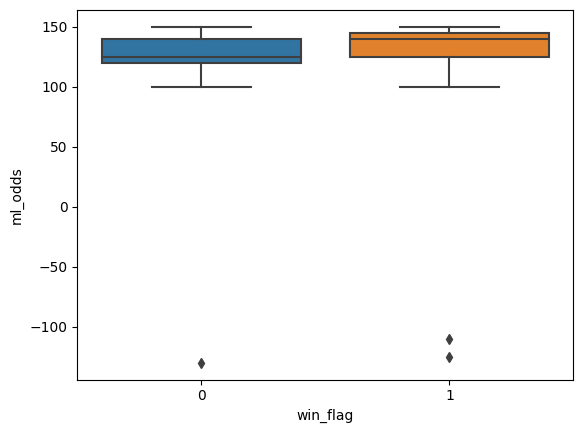

In [37]:
# Distribution of odds of the bets places
sns.boxplot(data = bets_placed, x = 'win_flag', y = 'ml_odds')

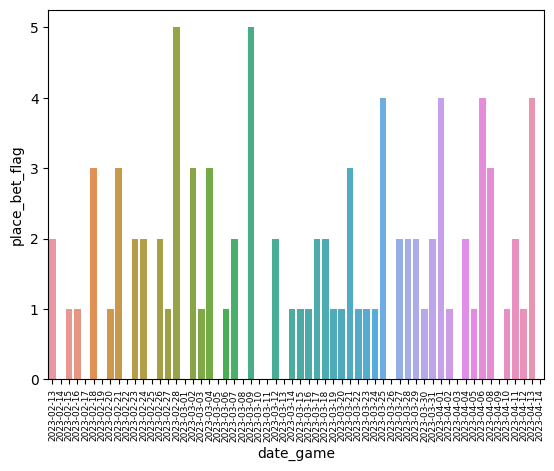

In [38]:
# How often do I place a bet
bets_placed_per_day = bet_analysis.groupby('date_game')['place_bet_flag'].sum().reset_index()
ax = sns.barplot(data = bets_placed_per_day, x = 'date_game', y = 'place_bet_flag');
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size = 6.5);

/var/folders/yk/qhxv13m50bl7fyrpnntydjgh0000gn/T/ipykernel_17944/3758619868.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size = 6.5);


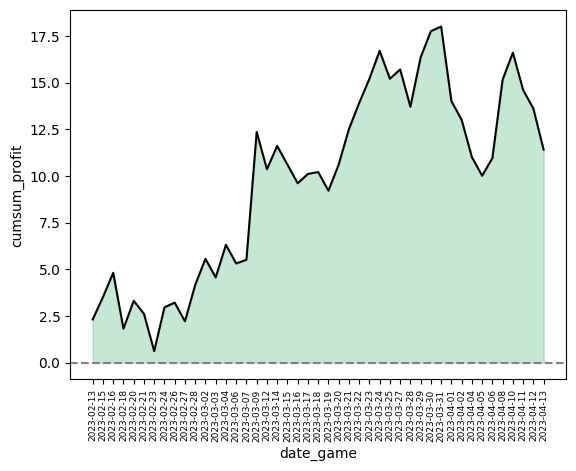

In [39]:
# What was my profit over time
# Create column that is the cumulative sum of profit
cumulative_profit = bets_placed.groupby('date_game')['profit'].sum().sort_index().cumsum().reset_index().rename(columns = {'profit':'cumsum_profit'})

# Plot
ax = sns.lineplot(data=cumulative_profit, x="date_game", y="cumsum_profit", color='black')
x = cumulative_profit['date_game']
y = cumulative_profit['cumsum_profit']

# Shade everything below 0 in red
ax.fill_between(x, y, where=(y < 0), interpolate=True, color='red', alpha=0.3)

# Shade everything above 0 in green
ax.fill_between(x, y, where=(y >= 0), interpolate=True, color='#3CB371', alpha=0.3)

# Axis ticks
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, size = 6.5);
plt.axhline(y=0, linestyle='--', color='gray')

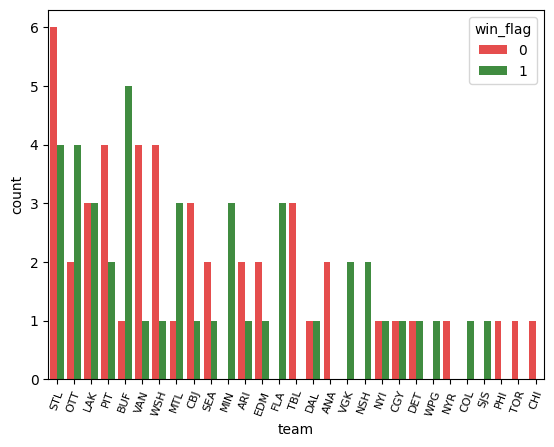

In [54]:
# What teams did I bet on the most?
ax = sns.countplot(x='team', hue='win_flag', data=bets_placed, palette={1: 'green', 0: 'red'},
              order=bets_placed['team'].value_counts().index,
              alpha = 0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, size = 8);

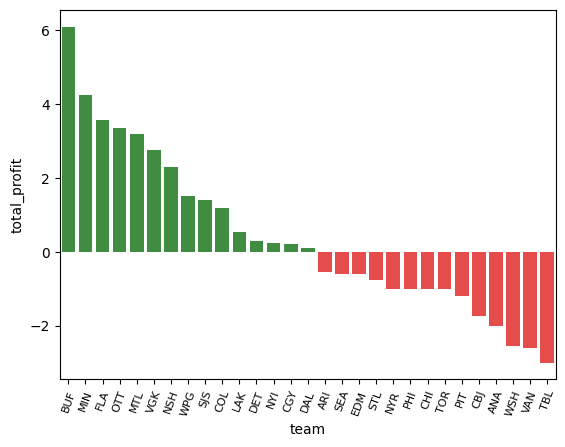

In [69]:
# How much profit was made per team
team_wise_profits = bets_placed.groupby('team').agg({'place_bet_flag':'count', 'profit':'sum'}).reset_index().rename(columns = {'place_bet_flag':'n_bets', 'profit':'total_profit'}).sort_values('total_profit', ascending=False)

ax = sns.barplot(data = team_wise_profits, x = 'team', y = 'total_profit', palette=np.where(team_wise_profits['total_profit'] >= 0, 'green', 'red'), alpha = 0.8)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, size = 8);

In [ ]:
# What was the average profit per team?
# What was the average odds per team?